In [2]:
from pickle import dump,load
import numpy as np
import optuna
from keras.models import Sequential
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
import time
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-06-23 16:11:10.599835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 16:11:11.334582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.enable_op_determinism()
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [4]:
print("TensorFlow Version:", tf.__version__)
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.13.1
CUDA Version: 11.8
cuDNN Version: 8
Num GPUs Available:  1


In [5]:
dataset_filtrado_path = 'nuevo_dataset_filtrado.csv'
nuevo_file_path = 'Nivel_Caudal_Asu_Con_1960_2024.csv'
dataset_filtrado = pd.read_csv(dataset_filtrado_path)
nuevo_data = pd.read_csv(nuevo_file_path)
dataset_filtrado['fecha'] = pd.to_datetime(dataset_filtrado['fecha'])
nuevo_data['fecha'] = pd.to_datetime(nuevo_data['fecha'])
columnas_adicionales = ['fecha', 'Qcon', 'Qasu_m']
nuevo_data = nuevo_data[columnas_adicionales]
dataset_combinado = pd.merge(dataset_filtrado, nuevo_data, on='fecha', how='left')
dataset_combinado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19366 entries, 0 to 19365
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   19366 non-null  datetime64[ns]
 1   e010    19359 non-null  float64       
 2   e134    19351 non-null  float64       
 3   e183    19341 non-null  float64       
 4   e218    19337 non-null  float64       
 5   Qcon    19351 non-null  float64       
 6   Qasu_m  19337 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


In [6]:
dataset_combinado.set_index('fecha',inplace=True)

In [7]:
df_interpolate = dataset_combinado.interpolate(limit = 15, method = 'quadratic', limit_direction = 'both')

In [8]:
df_interpolate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19366 entries, 1970-03-14 to 2023-03-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   e010    19366 non-null  float64
 1   e134    19366 non-null  float64
 2   e183    19366 non-null  float64
 3   e218    19366 non-null  float64
 4   Qcon    19366 non-null  float64
 5   Qasu_m  19366 non-null  float64
dtypes: float64(6)
memory usage: 1.0 MB


In [9]:
datos_norm = df_interpolate.copy() # Copia del dataframe 
datos_norm['Week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
datos_norm['Week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
datos_norm['Month'] = datos_norm.index.month
datos_norm['Month_sin'] = np.sin(2 * np.pi * datos_norm.index.month / 12)
datos_norm['Month_cos'] = np.cos(2 * np.pi * datos_norm.index.month / 12)
datos_norm['Year'] = datos_norm.index.year
datos_norm.rename(columns={'e218':'nivel'},inplace=True)
#horizonte = 28 # Cantidad de días a predecir
#tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
#cantidad_unidades = 30 # Cantidad de neuronas
#tamanio_batch = 30 # Tamaño del batch
#dropout = 0.25 # Probabilidad para desactivar una neurona
#features_set = 1 # Posición de características para el entrenamiento
year_ini = 73 # Año inicial
arch = 'GRU' # Arquictura del modelo
#modelo = arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)+'_d'+str(dropout)+'_f'+str(features_set)+'_y'+str(year_ini)

In [10]:
def preparar_datos(tamanio_ventana,horizonte, data): # Función para la división datos para el entrenamiento
    n_features=len(data.columns)
    x_train = np.zeros((len(data)-tamanio_ventana-horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros((len(data)-tamanio_ventana-horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1):
        x_train[(i-tamanio_ventana), :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[i-tamanio_ventana, :] = data['nivel'].iloc[(i):(i+horizonte)]
    return x_train,y_train

In [11]:
def create_model(trial, tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF):
    model = keras.Sequential()
    model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                             )
            )
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(horizonte))
    model.compile(optimizer='adam', loss=lossF, metrics=[RootMeanSquaredError()])
    return model

In [12]:
datos_norm.head()

,e010,e134,e183,nivel,Qcon,Qasu_m,Week_cos,Week_sin,Month,Month_sin,Month_cos,Year
fecha,,,,,,,,,,,,
1970-03-14,1.45,1.46,1.19,0.68,1343.6,1350.3,0.263587,0.964636,3,1.0,6.123234e-17,1970
1970-03-15,1.45,1.46,1.20,0.73,1343.6,1384.6,0.263587,0.964636,3,1.0,6.123234e-17,1970
1970-03-16,1.44,1.46,1.20,0.81,1343.6,1439.1,0.147647,0.98904,3,1.0,6.123234e-17,1970
1970-03-17,1.49,1.52,1.25,0.86,1374.0,1472.8,0.147647,0.98904,3,1.0,6.123234e-17,1970
1970-03-18,1.49,1.58,1.30,0.86,1404.1,1472.8,0.147647,0.98904,3,1.0,6.123234e-17,1970


In [13]:
orden=['nivel','e134','e183','e010','Qcon','Qasu_m','Week_cos','Week_sin','Month','Month_sin','Month_cos','Year']
datos_norm=datos_norm[orden]
datos_norm.isnull().sum()

nivel        0
e134         0
e183         0
e010         0
Qcon         0
Qasu_m       0
Week_cos     0
Week_sin     0
Month        0
Month_sin    0
Month_cos    0
Year         0
dtype: int64

In [14]:
def create_objective(datos_norm):
    def objective(trial):
        year_ini= 1973#trial.suggest_categorical('anho', [1973,1978,1983,1988,1993,1998])
        tamanio_ventana= trial.suggest_categorical('tamanio_ventana', [60,180,365,545])
        cantidad_unidades= trial.suggest_categorical('cantidad_unidades', [30,60,90,180])
        tamanio_batch=trial.suggest_categorical('batch', [120,180,360])
        dropout = trial.suggest_categorical('dropout', [0.1,0.2,0.3,0.4]) # 0.1, 0.2,0.3, 0.4, 0.5
        horizonte = trial.suggest_categorical('horizonte',[28])
        lossF = trial.suggest_categorical('lossF', ['mean_squared_error', 'mean_absolute_error'])
        lista=[['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos','Month'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Month_sin','Month_cos'],   
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos','Year']]
        features_set=trial.suggest_categorical('features', [0,1,2,3,4])
        
        seed = 42
        
        tf.random.set_seed(seed)
        np.random.seed(seed)
        datos = datos_norm[lista[features_set]]
        nfeatures = len(datos.columns)
        desde = (dt.datetime.strptime(str(year_ini)+'-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
        Scaler = MinMaxScaler()
        Scaler.fit(datos.loc[desde:'2022-12-31'])
        ix = datos.index
        datos_normm = pd.DataFrame(Scaler.transform(datos), columns=datos.columns)
        datos_normm.set_index(ix, inplace=True)
        
        initial_learning_rate = 0.001  # Adjusted learning rate
        
        Rmse = []
        Dtime = []
        maxError = []
        epocash = []
        Error_95 = []
        r2 = []
        hist=[]
        predicc = []
        yobs=[]
        ydate=[]
        xdate=[]
        print(f"tamanio_ventana: {tamanio_ventana} cantidad_unidades: {cantidad_unidades}")
        print(f"year {year_ini} batch {tamanio_batch} dropout {dropout} Features")
        print(lista[features_set])
        badTrial=False
        for valyear in [2017,2018,2019]:
            print(f'Validation year: {valyear}')
            trainScaled = datos_normm.loc[desde:str(valyear-1)+'-12-31']
            x_train, y_train = preparar_datos(tamanio_ventana, horizonte, trainScaled)

            
            desde = (dt.datetime.strptime(str(valyear)+'-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
            valScaled = datos_normm.loc[desde:str(valyear)+'-12-31']
            
            x_val, y_val = preparar_datos(tamanio_ventana, horizonte, valScaled)
           
            epocas = 10

            model = create_model(trial,tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF)
        
            
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            
            callbacks_list = [early_stopping, lr_scheduler]
            start_time = time.time()
            model.reset_states()
            
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list)
        
            Y_prediction = Scaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            y_val_inv = Scaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            yobs.append(y_val_inv)
            predicc.append(Y_prediction)
            #ydate.append(y_dates)
            #xdate.append(x_dates)
        
            mse = mean_squared_error(y_val_inv, Y_prediction)
            rmse = np.sqrt(mse)
            error = np.abs(y_val_inv - Y_prediction)
            Error_95_ = np.percentile(error, 95)
            maxError_ = max_error(y_val_inv, Y_prediction)
            r2_ = r2_score(y_val_inv, Y_prediction)
        
            print(f"MSE: {mse} RMSE: {rmse}")
            print(f"MaxError: {maxError_} R2: {r2_} Error95: {Error_95_}")
        
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time step: {elapsed_time:.6f} seconds")
        
            Rmse.append(rmse)
            Dtime.append(elapsed_time)
            maxError.append(maxError_) 
            Error_95.append(Error_95_) 
            epocash.append(len(history.history['loss']))
            r2.append(r2_)
            hist.append(history )
        
            if len(history.history['loss']) < epocas * 0.2:
                continue
        
        avg_score = np.mean(Rmse)
        min_score = np.min(Rmse)
        max_score = np.max(Rmse)
        
        max_err_mean = np.mean(maxError)
        max_err_min = np.min(maxError)
        max_err_max = np.max(maxError)
        r2_err_mean = np.mean(r2)
        avg_time = np.mean(Dtime)
        avg_Error_95 = np.mean(Error_95)
        
        print(f"Avg RMSE: {avg_score}, Min RMSE: {min_score}, Max RMSE: {max_score}")
        print(f"Avg MaxError: {max_err_mean}, Min MaxError: {max_err_min}, Max MaxError: {max_err_max}")
        print(f"Avg R2: {r2_err_mean}, Avg Time: {avg_time}, Avg Error95: {avg_Error_95}")

        trial.set_user_attr("mean_rmse", avg_score)
        trial.set_user_attr("min_rmse", min_score)
        trial.set_user_attr("max_rmse", max_score)
        trial.set_user_attr("maxError_mean", max_err_mean)
        trial.set_user_attr("maxError_min", max_err_min)
        trial.set_user_attr("maxError_max", max_err_max)
        trial.set_user_attr("Error95_mean", avg_Error_95)

        trial.set_user_attr("r2_mean", r2_err_mean)

        trial.set_user_attr("elapsed_time", avg_time )
        trial.set_user_attr("epocas",np.mean(np.array(epocash)) )
        if(badTrial):
            return 0.8,3


        return avg_score,avg_Error_95

    return objective

In [15]:
SEED = 42
study =optuna.create_study(directions=['minimize','minimize'],sampler=optuna.samplers.TPESampler(seed=SEED))
objective = create_objective(datos_norm)

[I 2024-06-23 16:11:24,138] A new study created in memory with name: no-name-eff89ac7-e3e8-4312-bc39-69c4fefee1dc


In [16]:
study.optimize(objective, n_trials=50, n_jobs=1)

tamanio_ventana: 180 cantidad_unidades: 180
year 1973 batch 180 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017


2024-06-23 16:11:29.733185: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:227] Using CUDA malloc Async allocator for GPU: 0
2024-06-23 16:11:29.733266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:03:00.0, compute capability: 7.5


Epoch 1/10


2024-06-23 16:11:33.839697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-06-23 16:11:33.990842: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd15c02de50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-23 16:11:33.990898: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-06-23 16:11:34.001237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-23 16:11:34.089122: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-23 16:11:34.175178: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 [==============================] - 9s 33ms/step - loss: 0.0767 - root_mean_squared_error: 0.1135 - val_loss: 0.0425 - val_root_mean_squared_error: 0.0576 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0441 - root_mean_squared_error: 0.0597 - val_loss: 0.0376 - val_root_mean_squared_error: 0.0533 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 3s 37ms/step - loss: 0.0404 - root_mean_squared_error: 0.0556 - val_loss: 0.0351 - val_root_mean_squared_error: 0.0492 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 3s 31ms/step - loss: 0.0368 - root_mean_squared_error: 0.0517 - val_loss: 0.0325 - val_root_mean_squared_error: 0.0458 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0347 - root_mean_squared_error: 0.0496 - val_loss: 0.0309 - val_root_mean_squared_error: 0.0442 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 3s 34ms/step - loss: 0.0336 - root_mean

[I 2024-06-23 16:12:18,179] Trial 0 finished with values: [1.2500942426381951, 2.4030903879330965] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 3}. 


MSE: 3.8268386232239107 RMSE: 1.9562307183008631
MaxError: 4.873654518127441 R2: 0.23130729933796623 Error95: 3.5798219351768497
Time step: 7.186994 seconds
Avg RMSE: 1.2500942426381951, Min RMSE: 0.41714002969560576, Max RMSE: 1.9562307183008631
Avg MaxError: 3.427782154083252, Min MaxError: 1.942646532058717, Max MaxError: 4.873654518127441
Avg R2: -0.42994400132393, Avg Time: 15.988747358322144, Avg Error95: 2.4030903879330965
tamanio_ventana: 545 cantidad_unidades: 90
year 1973 batch 120 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 13s 70ms/step - loss: 0.1005 - root_mean_squared_error: 0.1498 - val_loss: 0.0449 - val_root_mean_squared_error: 0.0574 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 7s 55ms/step - loss: 0.0531 - root_mean_squared_error: 0.0703 - val_loss: 0.0412 - val_root_mean_squared_error: 0.0573 - lr: 0.

[I 2024-06-23 16:14:16,061] Trial 1 finished with values: [1.725200427063075, 2.9918934040069574] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 6.012424082941478 RMSE: 2.452024486611314
MaxError: 5.474754457473754 R2: -0.2077087541120799 Error95: 4.180524856090545
Time step: 8.868418 seconds
Avg RMSE: 1.725200427063075, Min RMSE: 0.40441179789394505, Max RMSE: 2.452024486611314
Avg MaxError: 4.065822241306305, Min MaxError: 1.7600117492675795, Max MaxError: 5.474754457473754
Avg R2: -2.6258533196010805, Avg Time: 37.66304039955139, Avg Error95: 2.9918934040069574
tamanio_ventana: 180 cantidad_unidades: 90
year 1973 batch 120 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 8s 39ms/step - loss: 0.0927 - root_mean_squared_error: 0.1496 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0558 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 4s 27ms/step - loss: 0.0467 - root_mean_squared_error: 0.0627 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0524 - lr: 0.0010
Epoch 3

[I 2024-06-23 16:15:15,686] Trial 2 finished with values: [1.2860038404156526, 2.465534580310186] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 1}. 


MSE: 4.175133129694116 RMSE: 2.043314251331428
MaxError: 5.716824779510498 R2: 0.16134577987917542 Error95: 3.719749222278596
Time step: 7.679061 seconds
Avg RMSE: 1.2860038404156526, Min RMSE: 0.39740819305591973, Max RMSE: 2.043314251331428
Avg MaxError: 3.8034211460749314, Min MaxError: 1.7896642684936537, Max MaxError: 5.716824779510498
Avg R2: -0.5145862034524037, Avg Time: 18.37764859199524, Avg Error95: 2.465534580310186
tamanio_ventana: 545 cantidad_unidades: 180
year 1973 batch 360 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 9s 119ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 6s 128ms/step - loss: 0.0113 - root_mean_squared_error: 0.1061 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch

[I 2024-06-23 16:16:32,424] Trial 3 finished with values: [1.705235103328073, 2.968316345691681] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 180, 'batch': 360, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 3}. 


MSE: 8.704622935700888 RMSE: 2.9503597976689027
MaxError: 6.378965225219726 R2: -0.7484876608284119 Error95: 4.880234171867371
Time step: 8.089044 seconds
Avg RMSE: 1.705235103328073, Min RMSE: 0.4638286069312096, Max RMSE: 2.9503597976689027
Avg MaxError: 4.0647445360819505, Min MaxError: 1.815836811065675, Max MaxError: 6.378965225219726
Avg R2: -1.3588603578111955, Avg Time: 23.98426604270935, Avg Error95: 2.968316345691681
tamanio_ventana: 60 cantidad_unidades: 90
year 1973 batch 120 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 19ms/step - loss: 0.1048 - root_mean_squared_error: 0.1519 - val_loss: 0.0409 - val_root_mean_squared_error: 0.0535 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 15ms/step - loss: 0.0566 - root_mean_squared_error: 0.0746 - val_loss: 0.0360 - val_root_mean_squared_error: 0.0490 - lr: 0.0010

[I 2024-06-23 16:17:15,470] Trial 4 finished with values: [1.3236567374473651, 2.434692384719849] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 2}. 


MSE: 4.1180161168953 RMSE: 2.029289559647735
MaxError: 5.052656726837157 R2: 0.17281880896266522 Error95: 3.396295354604722
Time step: 7.201174 seconds
Avg RMSE: 1.3236567374473651, Min RMSE: 0.3960843815598749, Max RMSE: 2.029289559647735
Avg MaxError: 3.657948249181112, Min MaxError: 1.7720642662048354, Max MaxError: 5.052656726837157
Avg R2: -0.7345191492442424, Avg Time: 12.9710906346639, Avg Error95: 2.434692384719849
tamanio_ventana: 365 cantidad_unidades: 60
year 1973 batch 120 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 8s 34ms/step - loss: 0.0984 - root_mean_squared_error: 0.1548 - val_loss: 0.0486 - val_root_mean_squared_error: 0.0618 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 4s 28ms/step - loss: 0.0498 - root_mean_squared_error: 0.0664 - val_loss: 0.0422 - val_root_mean_squared_error: 0.0572 - lr: 0.0010
Epoch 3/10
134/134 [===============

[I 2024-06-23 16:18:19,539] Trial 5 finished with values: [1.3354893190341468, 2.5167888191541032] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 60, 'batch': 120, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 3.495225519188879 RMSE: 1.869552224247528
MaxError: 6.20177017211914 R2: 0.29791804455430404 Error95: 3.5050285210609435
Time step: 7.794786 seconds
Avg RMSE: 1.3354893190341468, Min RMSE: 0.41718251753790925, Max RMSE: 1.869552224247528
Avg MaxError: 4.19882558743159, Min MaxError: 1.8748855924606334, Max MaxError: 6.20177017211914
Avg R2: -1.033540445513049, Avg Time: 19.947820901870728, Avg Error95: 2.5167888191541032
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 12s 51ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 7s 51ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566 - lr: 0.0010
Epoch 

[I 2024-06-23 16:19:47,406] Trial 6 finished with values: [1.2888966473172558, 2.422355723222097] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 1}. 


MSE: 4.939420060654711 RMSE: 2.222480609736497
MaxError: 5.981472873687744 R2: 0.007824337538902992 Error95: 3.998548089027405
Time step: 8.678467 seconds
Avg RMSE: 1.2888966473172558, Min RMSE: 0.41779319275274723, Max RMSE: 2.222480609736497
Avg MaxError: 3.6272150389353435, Min MaxError: 1.5533923530578626, Max MaxError: 5.981472873687744
Avg R2: -0.2736621463292329, Avg Time: 27.841633796691895, Avg Error95: 2.422355723222097
tamanio_ventana: 60 cantidad_unidades: 60
year 1973 batch 120 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 17ms/step - loss: 0.1022 - root_mean_squared_error: 0.1642 - val_loss: 0.0479 - val_root_mean_squared_error: 0.0603 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0509 - root_mean_squared_error: 0.0678 - val_loss: 0.0389 - val_root_mean_squared_error: 0.0532 - lr: 0.0010
Epo

[I 2024-06-23 16:20:26,714] Trial 7 finished with values: [1.2792961726707932, 2.466526768843333] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 60, 'batch': 120, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 3}. 


MSE: 3.8445525484754537 RMSE: 1.9607530564748468
MaxError: 5.076261134147645 R2: 0.22774912341742992 Error95: 3.475005895137787
Time step: 5.567971 seconds
Avg RMSE: 1.2792961726707932, Min RMSE: 0.4076365623981945, Max RMSE: 1.9607530564748468
Avg MaxError: 3.576825674374899, Min MaxError: 1.7825838947296155, Max MaxError: 5.076261134147645
Avg R2: -0.5839533437783748, Avg Time: 11.753695805867514, Avg Error95: 2.466526768843333
tamanio_ventana: 365 cantidad_unidades: 90
year 1973 batch 360 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 7s 89ms/step - loss: 0.1417 - root_mean_squared_error: 0.2030 - val_loss: 0.0631 - val_root_mean_squared_error: 0.0770 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0635 - root_mean_squared_error: 0.0827 - val_loss: 0.0485 - val_root_mean_squared_error: 0.0621 - lr: 0.0010


[I 2024-06-23 16:21:12,053] Trial 8 finished with values: [1.505612399800088, 3.017953840335211] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 90, 'batch': 360, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 5.142219444161973 RMSE: 2.2676462343500523
MaxError: 5.53295030593872 R2: -0.032911742852556936 Error95: 4.281866762161255
Time step: 7.182764 seconds
Avg RMSE: 1.505612399800088, Min RMSE: 0.45469693342758355, Max RMSE: 2.2676462343500523
Avg MaxError: 4.2987945429484045, Min MaxError: 1.8719163846969615, Max MaxError: 5.53295030593872
Avg R2: -1.3092391695997403, Avg Time: 13.651620705922445, Avg Error95: 3.017953840335211
tamanio_ventana: 60 cantidad_unidades: 60
year 1973 batch 180 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 6s 20ms/step - loss: 0.1409 - root_mean_squared_error: 0.2005 - val_loss: 0.0499 - val_root_mean_squared_error: 0.0656 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 27ms/step - loss: 0.0711 - root_mean_squared_error: 0.0928 - val_loss: 0.0430 - val_root_mean_squared_error: 0.0594 - lr: 0.0010
E

[I 2024-06-23 16:21:49,741] Trial 9 finished with values: [1.4100056506258436, 2.6931748676300047] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 60, 'batch': 180, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 4.392675553192841 RMSE: 2.095871072655196
MaxError: 4.934200811386107 R2: 0.11764828189403098 Error95: 3.575743497610092
Time step: 6.688368 seconds
Avg RMSE: 1.4100056506258436, Min RMSE: 0.44565603427441186, Max RMSE: 2.095871072655196
Avg MaxError: 3.8460188754399613, Min MaxError: 1.9287856864929198, Max MaxError: 4.934200811386107
Avg R2: -1.0387847255783746, Avg Time: 11.176108360290527, Avg Error95: 2.6931748676300047
tamanio_ventana: 180 cantidad_unidades: 30
year 1973 batch 180 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 7s 27ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 19ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631 - lr: 0.0010
Epoch 

[I 2024-06-23 16:22:32,450] Trial 10 finished with values: [2.024191821700191, 3.768020422076186] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 30, 'batch': 180, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 3}. 


MSE: 6.793752396315934 RMSE: 2.606482763479539
MaxError: 8.697324142456054 R2: -0.36465327946171366 Error95: 4.933361836194993
Time step: 6.912109 seconds
Avg RMSE: 2.024191821700191, Min RMSE: 0.4824652735966771, Max RMSE: 2.9836274280243567
Avg MaxError: 5.710239526530107, Min MaxError: 1.8193522739410413, Max MaxError: 8.697324142456054
Avg R2: -4.77753070586041, Avg Time: 12.84703532854716, Avg Error95: 3.768020422076186
tamanio_ventana: 180 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 6s 34ms/step - loss: 0.0232 - root_mean_squared_error: 0.1524 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 44ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594 - lr: 0.0010
Epoch 3/10

[I 2024-06-23 16:23:22,311] Trial 11 finished with values: [1.3091147691329315, 2.430586134195328] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 3}. 


MSE: 3.292581654839178 RMSE: 1.8145472313608093
MaxError: 4.635499696731567 R2: 0.338622885990323 Error95: 3.164862218379975
Time step: 6.170776 seconds
Avg RMSE: 1.3091147691329315, Min RMSE: 0.43773451849292844, Max RMSE: 1.8145472313608093
Avg MaxError: 3.5424185339609786, Min MaxError: 1.8769658994674696, Max MaxError: 4.635499696731567
Avg R2: -0.9362464371897898, Avg Time: 15.028241634368896, Avg Error95: 2.430586134195328
tamanio_ventana: 180 cantidad_unidades: 180
year 1973 batch 180 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 6s 34ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 43ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - lr: 0.0010
Epoch 3/

[I 2024-06-23 16:24:12,350] Trial 12 finished with values: [1.3352689842684555, 2.4210845124721523] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 1}. 


MSE: 3.448711354248858 RMSE: 1.8570706379265325
MaxError: 4.286187295913696 R2: 0.3072612917060906 Error95: 3.2037310404777526
Time step: 7.769516 seconds
Avg RMSE: 1.3352689842684555, Min RMSE: 0.39918636921072054, Max RMSE: 1.8570706379265325
Avg MaxError: 3.409559855461121, Min MaxError: 1.7383145427703868, Max MaxError: 4.286187295913696
Avg R2: -1.0866644407405674, Avg Time: 15.287885506947836, Avg Error95: 2.4210845124721523
tamanio_ventana: 180 cantidad_unidades: 180
year 1973 batch 180 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 8s 34ms/step - loss: 0.0823 - root_mean_squared_error: 0.1252 - val_loss: 0.0381 - val_root_mean_squared_error: 0.0508 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0446 - root_mean_squared_error: 0.0601 - val_loss: 0.0357 - val_root_mean_squared_error: 0.0506 - lr: 0.00

[I 2024-06-23 16:25:01,708] Trial 13 finished with values: [1.3106925696027556, 2.5551696680386864] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 2}. 


MSE: 3.9705983497814556 RMSE: 1.9926360304334196
MaxError: 5.683783617019653 R2: 0.20243044736325244 Error95: 3.8344570231437687
Time step: 7.865182 seconds
Avg RMSE: 1.3106925696027556, Min RMSE: 0.39652214940405656, Max RMSE: 1.9926360304334196
Avg MaxError: 3.863518602053324, Min MaxError: 1.8311019945144666, Max MaxError: 5.683783617019653
Avg R2: -0.7198872053523421, Avg Time: 15.046003580093384, Avg Error95: 2.5551696680386864
tamanio_ventana: 180 cantidad_unidades: 30
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 6s 30ms/step - loss: 0.1845 - root_mean_squared_error: 0.2516 - val_loss: 0.0554 - val_root_mean_squared_error: 0.0776 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 19ms/step - loss: 0.0912 - root_mean_squared_error: 0.1199 - val_loss: 0.0477 - val_root_mean_squared_error: 0.0675 - lr: 0.0010
Epoch 3/10
90/90 [===========

[I 2024-06-23 16:25:43,038] Trial 14 finished with values: [2.258712807092582, 4.532253592217962] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 30, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 10.443573797501166 RMSE: 3.2316518682403226
MaxError: 12.070061254501343 R2: -1.0977887330407832 Error95: 6.439074545383454
Time step: 6.243818 seconds
Avg RMSE: 2.258712807092582, Min RMSE: 0.47775390729174877, Max RMSE: 3.2316518682403226
Avg MaxError: 7.2366119929154715, Min MaxError: 2.064164152145387, Max MaxError: 12.070061254501343
Avg R2: -5.316849802378681, Avg Time: 12.384202241897583, Avg Error95: 4.532253592217962
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 360 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 8s 94ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 4s 90ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657 - lr: 0.0010
Epoc

[I 2024-06-23 16:26:43,078] Trial 15 finished with values: [1.7966911700769763, 3.359143392403921] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 360, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 3}. 


MSE: 11.887872494850816 RMSE: 3.4478794199987353
MaxError: 7.637376785278319 R2: -1.38790336172953 Error95: 6.077444431304932
Time step: 8.052530 seconds
Avg RMSE: 1.7966911700769763, Min RMSE: 0.4831843349117327, Max RMSE: 3.4478794199987353
Avg MaxError: 4.454446385701497, Min MaxError: 1.7291410636901867, Max MaxError: 7.637376785278319
Avg R2: -1.1261049899118571, Avg Time: 18.592575073242188, Avg Error95: 3.359143392403921
tamanio_ventana: 545 cantidad_unidades: 180
year 1973 batch 180 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 10s 75ms/step - loss: 0.0996 - root_mean_squared_error: 0.1457 - val_loss: 0.0446 - val_root_mean_squared_error: 0.0560 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 6s 67ms/step - loss: 0.0527 - root_mean_squared_error: 0.0696 - val_loss: 0.0392 - val_root_mean_squared_error: 0.0528 - lr: 0.0010
Epoch 

[I 2024-06-23 16:28:16,160] Trial 16 finished with values: [1.614068267656543, 2.8596770305633554] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 3}. 


MSE: 5.5273480808760675 RMSE: 2.3510312802844773
MaxError: 5.108227748870849 R2: -0.11027209195675858 Error95: 4.089877383232118
Time step: 9.340239 seconds
Avg RMSE: 1.614068267656543, Min RMSE: 0.434899799571025, Max RMSE: 2.3510312802844773
Avg MaxError: 4.004007373650869, Min MaxError: 1.902632327079774, Max MaxError: 5.108227748870849
Avg R2: -1.9235713337524283, Avg Time: 29.564521948496502, Avg Error95: 2.8596770305633554
tamanio_ventana: 180 cantidad_unidades: 30
year 1973 batch 180 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 7s 27ms/step - loss: 0.1605 - root_mean_squared_error: 0.2356 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0670 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 2s 19ms/step - loss: 0.0702 - root_mean_squared_error: 0.0921 - val_loss: 0.0454 - val_root_mean_squared_error: 0.0619 - lr: 0.0010
Epoch 3/1

[I 2024-06-23 16:28:58,901] Trial 17 finished with values: [1.918951161105045, 4.032821677019199] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 30, 'batch': 180, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 1}. 


MSE: 7.096444856639209 RMSE: 2.663915324600091
MaxError: 7.647530508041381 R2: -0.42545476802825144 Error95: 5.452320630788804
Time step: 5.471056 seconds
Avg RMSE: 1.918951161105045, Min RMSE: 0.4407406390880529, Max RMSE: 2.663915324600091
Avg MaxError: 5.627887016932171, Min MaxError: 1.9216200733184827, Max MaxError: 7.647530508041381
Avg R2: -3.684295752025248, Avg Time: 12.831854025522867, Avg Error95: 4.032821677019199
tamanio_ventana: 180 cantidad_unidades: 180
year 1973 batch 360 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 6s 53ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575 - lr: 0.0010
Ep

[I 2024-06-23 16:29:40,802] Trial 18 finished with values: [1.4375776501276138, 2.7529891630808514] and parameters: {'tamanio_ventana': 180, 'cantidad_unidades': 180, 'batch': 360, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 2}. 


MSE: 6.691694146101506 RMSE: 2.58683090790672
MaxError: 6.576125373840331 R2: -0.34415295538061086 Error95: 4.92114755153656
Time step: 5.850581 seconds
Avg RMSE: 1.4375776501276138, Min RMSE: 0.4338420808823126, Max RMSE: 2.58683090790672
Avg MaxError: 4.340577526092528, Min MaxError: 1.8110732364654543, Max MaxError: 6.576125373840331
Avg R2: -0.49285071592481877, Avg Time: 12.30219316482544, Avg Error95: 2.7529891630808514
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 9s 54ms/step - loss: 0.1000 - root_mean_squared_error: 0.1435 - val_loss: 0.0484 - val_root_mean_squared_error: 0.0609 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 47ms/step - loss: 0.0551 - root_mean_squared_error: 0.0729 - val_loss: 0.0442 - val_root_mean_squared_error: 0.0619 - lr: 0.0010
Epoch 3/10
90/90 [=================

[I 2024-06-23 16:30:51,113] Trial 19 finished with values: [1.2521812732342548, 2.3044063165187834] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.384887026908396 RMSE: 1.544307944326
MaxError: 4.459500126838684 R2: 0.5209504685244213 Error95: 2.774862336158752
Time step: 8.054099 seconds
Avg RMSE: 1.2521812732342548, Min RMSE: 0.47231160733562244, Max RMSE: 1.7399242680411415
Avg MaxError: 3.506545349756877, Min MaxError: 2.0021602630615245, Max MaxError: 4.459500126838684
Avg R2: -1.0161912592193538, Avg Time: 22.005131165186565, Avg Error95: 2.3044063165187834
tamanio_ventana: 365 cantidad_unidades: 60
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 7s 38ms/step - loss: 0.1451 - root_mean_squared_error: 0.2039 - val_loss: 0.0567 - val_root_mean_squared_error: 0.0701 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 3s 29ms/step - loss: 0.0732 - root_mean_squared_error: 0.0963 - val_loss: 0.0452 - val_root_mean_squared_error: 0.0609 - lr: 0.0010
Epoch 3/10
90/90 [==================

[I 2024-06-23 16:31:45,378] Trial 20 finished with values: [1.6955175891383574, 3.195539491415024] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 60, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 6.473740586695994 RMSE: 2.5443546503378798
MaxError: 6.314855127334594 R2: -0.300372872995746 Error95: 4.7007550630569455
Time step: 7.455505 seconds
Avg RMSE: 1.6955175891383574, Min RMSE: 0.5127239043376715, Max RMSE: 2.5443546503378798
Avg MaxError: 4.438067609469096, Min MaxError: 2.139303607940675, Max MaxError: 6.314855127334594
Avg R2: -1.9461808042712951, Avg Time: 16.644654591878254, Avg Error95: 3.195539491415024
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 8s 54ms/step - loss: 0.1054 - root_mean_squared_error: 0.1561 - val_loss: 0.0475 - val_root_mean_squared_error: 0.0612 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 47ms/step - loss: 0.0545 - root_mean_squared_error: 0.0721 - val_loss: 0.0425 - val_root_mean_squared_error: 0.0594 - lr: 0.0010
Epoch 3/10
90/90 [===============

[I 2024-06-23 16:32:52,144] Trial 21 finished with values: [1.2306241341430093, 2.1962855485280364] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.6547333627937637 RMSE: 1.629335251810923
MaxError: 3.9120339584350585 R2: 0.46674674343482514 Error95: 2.751029236555099
Time step: 6.394481 seconds
Avg RMSE: 1.2306241341430093, Min RMSE: 0.46317630386906605, Max RMSE: 1.629335251810923
Avg MaxError: 3.1693513234456385, Min MaxError: 1.9766322898864757, Max MaxError: 3.9120339584350585
Avg R2: -0.7548120440642689, Avg Time: 20.83130915959676, Avg Error95: 2.1962855485280364
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 9s 61ms/step - loss: 0.1023 - root_mean_squared_error: 0.1504 - val_loss: 0.0466 - val_root_mean_squared_error: 0.0606 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 46ms/step - loss: 0.0548 - root_mean_squared_error: 0.0726 - val_loss: 0.0427 - val_root_mean_squared_error: 0.0607 - lr: 0.0010
Epoch 3/10
90/90 [===========

[I 2024-06-23 16:34:01,815] Trial 22 finished with values: [1.265732061981828, 2.3117088194688162] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.7286104448497635 RMSE: 1.6518506121468017
MaxError: 3.8981932544708253 R2: 0.451907138394251 Error95: 2.933879082679749
Time step: 7.898650 seconds
Avg RMSE: 1.265732061981828, Min RMSE: 0.4835730924674985, Max RMSE: 1.6617724813311836
Avg MaxError: 3.1940237538019822, Min MaxError: 2.056133794784547, Max MaxError: 3.8981932544708253
Avg R2: -0.885965700096583, Avg Time: 21.812060991923016, Avg Error95: 2.3117088194688162
tamanio_ventana: 365 cantidad_unidades: 30
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 8s 37ms/step - loss: 0.1753 - root_mean_squared_error: 0.2424 - val_loss: 0.0621 - val_root_mean_squared_error: 0.0790 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 3s 29ms/step - loss: 0.0905 - root_mean_squared_error: 0.1194 - val_loss: 0.0494 - val_root_mean_squared_error: 0.0662 - lr: 0.0010
Epoch 3/10
90/90 [===============

[I 2024-06-23 16:34:56,537] Trial 23 finished with values: [1.9996675252157416, 3.8058115750551225] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 30, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 5.588273299714099 RMSE: 2.363952897101399
MaxError: 5.964923861026764 R2: -0.12251007103505529 Error95: 4.6112216930389405
Time step: 7.355717 seconds
Avg RMSE: 1.9996675252157416, Min RMSE: 0.4705478821907325, Max RMSE: 3.164501796355094
Avg MaxError: 5.2041299533844, Min MaxError: 2.0689745712280287, Max MaxError: 7.578491427898407
Avg R2: -5.3486766869304345, Avg Time: 16.8307945728302, Avg Error95: 3.8058115750551225
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 360 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 7s 86ms/step - loss: 0.1334 - root_mean_squared_error: 0.1875 - val_loss: 0.0599 - val_root_mean_squared_error: 0.0712 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 3s 70ms/step - loss: 0.0672 - root_mean_squared_error: 0.0877 - val_loss: 0.0463 - val_root_mean_squared_error: 0.0609 - lr: 0.0010
Epoch 3/10
45/45 [=================

[I 2024-06-23 16:35:54,853] Trial 24 finished with values: [1.7263563478929758, 3.032343808253607] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 360, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 9.467850592362453 RMSE: 3.076987259051043
MaxError: 6.018561601638793 R2: -0.9017963279508523 Error95: 4.97367294883728
Time step: 7.638580 seconds
Avg RMSE: 1.7263563478929758, Min RMSE: 0.4643922647171598, Max RMSE: 3.076987259051043
Avg MaxError: 3.9091466442743936, Min MaxError: 2.0305176877975475, Max MaxError: 6.018561601638793
Avg R2: -1.2844946506703943, Avg Time: 17.73290141423543, Avg Error95: 3.032343808253607
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 9s 54ms/step - loss: 0.0992 - root_mean_squared_error: 0.1436 - val_loss: 0.0488 - val_root_mean_squared_error: 0.0628 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4s 47ms/step - loss: 0.0541 - root_mean_squared_error: 0.0716 - val_loss: 0.0460 - val_root_mean_squared_error: 0.0643 - lr: 0.0010
Epoch 3/10
90/90 [=================

[I 2024-06-23 16:37:04,190] Trial 25 finished with values: [1.3167186835777616, 2.382117341756821] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.776239580578884 RMSE: 1.6662051436059377
MaxError: 3.9739441967010496 R2: 0.44233992833432634 Error95: 2.924228569030763
Time step: 7.957715 seconds
Avg RMSE: 1.3167186835777616, Min RMSE: 0.4539698349474846, Max RMSE: 1.8299810721798622
Avg MaxError: 3.4149288972218828, Min MaxError: 2.009834165573121, Max MaxError: 4.261008329391479
Avg R2: -1.2264287637384916, Avg Time: 21.699494123458862, Avg Error95: 2.382117341756821
tamanio_ventana: 545 cantidad_unidades: 180
year 1973 batch 180 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 10s 73ms/step - loss: 0.0202 - root_mean_squared_error: 0.1421 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 6s 67ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628 - lr: 0.0010
Epoch 3/10
90/90 [============

[I 2024-06-23 16:38:29,307] Trial 26 finished with values: [1.6329843553878192, 2.6674681289593387] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 0}. 


MSE: 4.9618203688097156 RMSE: 2.227514392503383
MaxError: 4.582605257034301 R2: 0.0033248132404819497 Error95: 3.6304470393657686
Time step: 7.106205 seconds
Avg RMSE: 1.6329843553878192, Min RMSE: 0.44596999643293095, Max RMSE: 2.227514392503383
Avg MaxError: 3.8126008073488875, Min MaxError: 1.999516983032228, Max MaxError: 4.855680181980134
Avg R2: -2.3158988487922927, Avg Time: 26.91513665517171, Avg Error95: 2.6674681289593387
tamanio_ventana: 60 cantidad_unidades: 60
year 1973 batch 360 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 5s 31ms/step - loss: 0.1711 - root_mean_squared_error: 0.2389 - val_loss: 0.0720 - val_root_mean_squared_error: 0.0931 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 1s 14ms/step - loss: 0.0925 - root_mean_squared_error: 0.1206 - val_loss: 0.0600 - val_root_mean_squared_error: 0.0792 - lr: 0.0010
Epoch 3/10
45/45 [=============

[I 2024-06-23 16:38:58,200] Trial 27 finished with values: [1.7518033427328004, 3.6713758326570223] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 60, 'batch': 360, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 6.681436072988115 RMSE: 2.5848473983947513
MaxError: 10.359281663894654 R2: -0.342092427957984 Error95: 5.572240605115898
Time step: 4.992913 seconds
Avg RMSE: 1.7518033427328004, Min RMSE: 0.47353074888106417, Max RMSE: 2.5848473983947513
Avg MaxError: 6.144312671422959, Min MaxError: 2.0662511491775524, Max MaxError: 10.359281663894654
Avg R2: -2.3650783677458054, Avg Time: 8.250640233357748, Avg Error95: 3.6713758326570223
tamanio_ventana: 365 cantidad_unidades: 30
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 8s 53ms/step - loss: 0.1860 - root_mean_squared_error: 0.2565 - val_loss: 0.0633 - val_root_mean_squared_error: 0.0836 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 3s 30ms/step - loss: 0.0894 - root_mean_squared_error: 0.1181 - val_loss: 0.0520 - val_root_mean_squared_error: 0.0679 - lr: 0.0010
Epoch 3/10
90/90 [=============

[I 2024-06-23 16:39:51,301] Trial 28 finished with values: [1.8175395206422589, 3.5575738093256954] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 30, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 7.727007302304216 RMSE: 2.779749503517217
MaxError: 9.165410586595534 R2: -0.5521151258371075 Error95: 5.4056457527279855
Time step: 5.957216 seconds
Avg RMSE: 1.8175395206422589, Min RMSE: 0.4690384746710467, Max RMSE: 2.779749503517217
Avg MaxError: 5.474400767087936, Min MaxError: 1.9608480548858656, Max MaxError: 9.165410586595534
Avg R2: -2.4513574316405657, Avg Time: 15.937282085418701, Avg Error95: 3.5575738093256954
tamanio_ventana: 545 cantidad_unidades: 90
year 1973 batch 120 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 13s 65ms/step - loss: 0.0980 - root_mean_squared_error: 0.1461 - val_loss: 0.0452 - val_root_mean_squared_error: 0.0600 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 8s 63ms/step - loss: 0.0526 - root_mean_squared_error: 0.0697 - val_loss: 0.0402 - val_root_mean_squared_error: 0.0557 - lr: 0.0

[I 2024-06-23 16:41:38,892] Trial 29 finished with values: [1.8461761231793468, 3.188439926306407] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 6.881090250507421 RMSE: 2.623183228542646
MaxError: 5.378914318084716 R2: -0.3821967344172097 Error95: 4.426607431411743
Time step: 9.211083 seconds
Avg RMSE: 1.8461761231793468, Min RMSE: 0.40363776058986006, Max RMSE: 2.623183228542646
Avg MaxError: 4.018422032992046, Min MaxError: 1.7352138614654553, Max MaxError: 5.378914318084716
Avg R2: -3.232116933337403, Avg Time: 34.356642723083496, Avg Error95: 3.188439926306407
tamanio_ventana: 365 cantidad_unidades: 90
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 7s 45ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 3s 39ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546 - lr: 0.0010
Ep

[I 2024-06-23 16:42:41,883] Trial 30 finished with values: [1.5718746240709234, 2.9152223347822823] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 90, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 2}. 


MSE: 4.655222427439227 RMSE: 2.157596446845245
MaxError: 7.3825733184814455 R2: 0.06491079132151034 Error95: 3.9662091956138608
Time step: 8.814540 seconds
Avg RMSE: 1.5718746240709234, Min RMSE: 0.45489012239884563, Max RMSE: 2.157596446845245
Avg MaxError: 5.286570158104102, Min MaxError: 1.6638324546813976, Max MaxError: 7.3825733184814455
Avg R2: -1.985818650671727, Avg Time: 19.526232560475666, Avg Error95: 2.9152223347822823
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 180 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
90/90 [==============================] - 10s 54ms/step - loss: 0.1023 - root_mean_squared_error: 0.1497 - val_loss: 0.0470 - val_root_mean_squared_error: 0.0605 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 5s 52ms/step - loss: 0.0548 - root_mean_squared_error: 0.0726 - val_loss: 0.0431 - val_root_mean_squared_error: 0.0609 - lr: 0.0010
Epoch 3/10
90/90 [===========

[I 2024-06-23 16:43:49,610] Trial 31 finished with values: [1.215720622629355, 2.189917426586151] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 180, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.406691423586881 RMSE: 1.5513514829292816
MaxError: 3.693192262649536 R2: 0.5165706442832384 Error95: 2.6503615574836727
Time step: 6.815677 seconds
Avg RMSE: 1.215720622629355, Min RMSE: 0.4583193228830322, Max RMSE: 1.6374910620757517
Avg MaxError: 3.0704998588562016, Min MaxError: 2.004670047760011, Max MaxError: 3.693192262649536
Avg R2: -0.8095150154295561, Avg Time: 21.154205163319904, Avg Error95: 2.189917426586151
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 10s 48ms/step - loss: 0.0845 - root_mean_squared_error: 0.1227 - val_loss: 0.0438 - val_root_mean_squared_error: 0.0565 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 6s 42ms/step - loss: 0.0491 - root_mean_squared_error: 0.0657 - val_loss: 0.0382 - val_root_mean_squared_error: 0.0534 - lr: 0.0010
Epoch 3/10
134/134 [========

[I 2024-06-23 16:45:12,810] Trial 32 finished with values: [1.0261380712243204, 1.9007590531508134] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.1387285013086377 RMSE: 1.4624392299540647
MaxError: 3.64225266456604 R2: 0.5703960502340713 Error95: 2.5699645118713383
Time step: 7.307647 seconds
Avg RMSE: 1.0261380712243204, Min RMSE: 0.4311239197210312, Max RMSE: 1.4624392299540647
Avg MaxError: 2.858846020698548, Min MaxError: 1.9108398246765148, Max MaxError: 3.64225266456604
Avg R2: -0.030708298101048397, Avg Time: 25.92710812886556, Avg Error95: 1.9007590531508134
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 9s 46ms/step - loss: 0.0860 - root_mean_squared_error: 0.1273 - val_loss: 0.0438 - val_root_mean_squared_error: 0.0566 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 6s 44ms/step - loss: 0.0496 - root_mean_squared_error: 0.0662 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0548 - lr: 0.0010
Epoch 3/10
134/134 [=======

[I 2024-06-23 16:46:34,103] Trial 33 finished with values: [1.018668538655036, 1.8721394293522577] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 1.9295306384092608 RMSE: 1.389075461740384
MaxError: 4.174354491233826 R2: 0.6124173858683852 Error95: 2.410798305814189
Time step: 8.526274 seconds
Avg RMSE: 1.018668538655036, Min RMSE: 0.4342717307251314, Max RMSE: 1.389075461740384
Avg MaxError: 3.0869726149241132, Min MaxError: 1.9468298339843764, Max MaxError: 4.174354491233826
Avg R2: -0.08570878112339304, Avg Time: 25.67060724894206, Avg Error95: 1.8721394293522577
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 19ms/step - loss: 0.0901 - root_mean_squared_error: 0.1294 - val_loss: 0.0410 - val_root_mean_squared_error: 0.0535 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0517 - root_mean_squared_error: 0.0685 - val_loss: 0.0369 - val_root_mean_squared_error: 0.0524 - lr: 0.001

[I 2024-06-23 16:47:17,644] Trial 34 finished with values: [1.3749144760156036, 2.4471028437614444] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 4.4720056541138815 RMSE: 2.1147117189143967
MaxError: 4.586123371124268 R2: 0.10171333518613634 Error95: 3.2733690381050113
Time step: 7.190394 seconds
Avg RMSE: 1.3749144760156036, Min RMSE: 0.41837986975319524, Max RMSE: 2.1147117189143967
Avg MaxError: 3.4673526096344, Min MaxError: 1.8583568668365489, Max MaxError: 4.586123371124268
Avg R2: -0.8492508296605298, Avg Time: 12.719079653422037, Avg Error95: 2.4471028437614444
tamanio_ventana: 545 cantidad_unidades: 90
year 1973 batch 120 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 13s 65ms/step - loss: 0.1070 - root_mean_squared_error: 0.1568 - val_loss: 0.0437 - val_root_mean_squared_error: 0.0565 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 8s 57ms/step - loss: 0.0554 - root_mean_squared_error: 0.0731 - val_loss: 0.0404 - val_root_mean_squared_error: 0.0560 - lr: 0.0010
Ep

[I 2024-06-23 16:49:02,058] Trial 35 finished with values: [1.6984234085956862, 3.0529538293679557] and parameters: {'tamanio_ventana': 545, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 1}. 


MSE: 5.946041982911476 RMSE: 2.438450734157136
MaxError: 5.838147907257079 R2: -0.19437465754526628 Error95: 4.3020291905403125
Time step: 10.361434 seconds
Avg RMSE: 1.6984234085956862, Min RMSE: 0.42215904319982245, Max RMSE: 2.438450734157136
Avg MaxError: 4.450285634994507, Min MaxError: 1.8063311576843275, Max MaxError: 5.838147907257079
Avg R2: -2.399297605815393, Avg Time: 33.31990257898966, Avg Error95: 3.0529538293679557
tamanio_ventana: 365 cantidad_unidades: 180
year 1973 batch 120 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 10s 47ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 6s 47ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - lr: 0.0010
Epoch 3/10
134/134 [======

[I 2024-06-23 16:50:25,879] Trial 36 finished with values: [1.2296243770942081, 2.212711051623027] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 0}. 


MSE: 3.982391975208577 RMSE: 1.995593138695505
MaxError: 4.139207649230956 R2: 0.20006147530230556 Error95: 3.3232133162021644
Time step: 8.431399 seconds
Avg RMSE: 1.2296243770942081, Min RMSE: 0.4240030155628364, Max RMSE: 1.995593138695505
Avg MaxError: 3.016264661153157, Min MaxError: 1.7799573326110854, Max MaxError: 4.139207649230956
Avg R2: -0.27432436863792736, Avg Time: 26.529223998387653, Avg Error95: 2.212711051623027
tamanio_ventana: 365 cantidad_unidades: 60
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 8s 33ms/step - loss: 0.1408 - root_mean_squared_error: 0.2037 - val_loss: 0.0449 - val_root_mean_squared_error: 0.0579 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 4s 29ms/step - loss: 0.0670 - root_mean_squared_error: 0.0877 - val_loss: 0.0431 - val_root_mean_squared_error: 0.0563 - lr: 0.0

[I 2024-06-23 16:51:31,957] Trial 37 finished with values: [1.5479634229573715, 2.9840196514129644] and parameters: {'tamanio_ventana': 365, 'cantidad_unidades': 60, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 2}. 


MSE: 4.9649501842735715 RMSE: 2.22821681715976
MaxError: 5.7110654354095445 R2: 0.0026961307852342298 Error95: 4.055503817081451
Time step: 8.106567 seconds
Avg RMSE: 1.5479634229573715, Min RMSE: 0.4068801243379879, Max RMSE: 2.22821681715976
Avg MaxError: 4.449845205545425, Min MaxError: 1.5970401144027724, Max MaxError: 6.041430066823959
Avg R2: -1.7645312545231928, Avg Time: 20.571930090586346, Avg Error95: 2.9840196514129644
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 19ms/step - loss: 0.0866 - root_mean_squared_error: 0.1259 - val_loss: 0.0450 - val_root_mean_squared_error: 0.0590 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0497 - root_mean_squared_error: 0.0664 - val_loss: 0.0401 - val_root_mean_squared_error: 0.0538 - lr: 0.0010
Epoch 3/10
134/134 [========

[I 2024-06-23 16:52:14,508] Trial 38 finished with values: [0.9588447700511749, 1.8476280771096552] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.555907323979885 RMSE: 1.5987205271653595
MaxError: 3.8769271659851077 R2: 0.48659781690590165 Error95: 2.8466817846298214
Time step: 5.964848 seconds
Avg RMSE: 0.9588447700511749, Min RMSE: 0.45048551298224543, Max RMSE: 1.5987205271653595
Avg MaxError: 2.9083889468510953, Min MaxError: 1.996806941032411, Max MaxError: 3.8769271659851077
Avg R2: 0.35992437050744197, Avg Time: 12.832492113113403, Avg Error95: 1.8476280771096552
tamanio_ventana: 60 cantidad_unidades: 90
year 1973 batch 120 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 8s 28ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568 - lr: 0.0010
E

[I 2024-06-23 16:52:59,679] Trial 39 finished with values: [1.0946503936079344, 2.1025723822116853] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 1}. 


MSE: 2.525817891562327 RMSE: 1.589282193810252
MaxError: 3.93252010345459 R2: 0.49264184680726053 Error95: 2.835246579885482
Time step: 7.121879 seconds
Avg RMSE: 1.0946503936079344, Min RMSE: 0.410650630489143, Max RMSE: 1.589282193810252
Avg MaxError: 3.296966039339702, Min MaxError: 1.6310594749450695, Max MaxError: 4.327318539619446
Avg R2: -0.19539022815082638, Avg Time: 13.673995018005371, Avg Error95: 2.1025723822116853
tamanio_ventana: 60 cantidad_unidades: 90
year 1973 batch 120 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 22ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541 - lr: 0.0010
Epoch 3/

[I 2024-06-23 16:53:43,401] Trial 40 finished with values: [1.2252150192772693, 2.3972231529553736] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 1}. 


MSE: 3.330760234536195 RMSE: 1.8250370501817752
MaxError: 4.614449810981751 R2: 0.33095399831979544 Error95: 3.384000730276108
Time step: 7.120906 seconds
Avg RMSE: 1.2252150192772693, Min RMSE: 0.4095792959447801, Max RMSE: 1.8250370501817752
Avg MaxError: 3.3906708558400473, Min MaxError: 1.7397159576416028, Max MaxError: 4.614449810981751
Avg R2: -0.5012176551750609, Avg Time: 13.192219495773315, Avg Error95: 2.3972231529553736
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 22ms/step - loss: 0.0879 - root_mean_squared_error: 0.1295 - val_loss: 0.0439 - val_root_mean_squared_error: 0.0596 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0494 - root_mean_squared_error: 0.0661 - val_loss: 0.0399 - val_root_mean_squared_error: 0.0532 - lr: 0.0010
Epoch 3/10
134/134 [=======

[I 2024-06-23 16:54:27,978] Trial 41 finished with values: [0.9701874469883677, 1.861721823136012] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 2.6100670377928714 RMSE: 1.615570189683157
MaxError: 3.988978633880615 R2: 0.4757188170898826 Error95: 2.894444265127183
Time step: 7.198644 seconds
Avg RMSE: 0.9701874469883677, Min RMSE: 0.44152273218660726, Max RMSE: 1.615570189683157
Avg MaxError: 2.9701194270451867, Min MaxError: 2.0073966693878185, Max MaxError: 3.988978633880615
Avg R2: 0.33297634151928795, Avg Time: 13.056360801060995, Avg Error95: 1.861721823136012
tamanio_ventana: 60 cantidad_unidades: 30
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 7s 19ms/step - loss: 0.1917 - root_mean_squared_error: 0.2744 - val_loss: 0.0615 - val_root_mean_squared_error: 0.0806 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0890 - root_mean_squared_error: 0.1169 - val_loss: 0.0477 - val_root_mean_squared_error: 0.0651 - lr: 0.001

[I 2024-06-23 16:55:09,447] Trial 42 finished with values: [1.5802292514380873, 3.054855153004329] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 30, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 4}. 


MSE: 3.6562851438983657 RMSE: 1.9121415072892398
MaxError: 6.7659587574005124 R2: 0.26556618180937086 Error95: 3.678876574516297
Time step: 6.930298 seconds
Avg RMSE: 1.5802292514380873, Min RMSE: 0.4251691289721661, Max RMSE: 2.403377118052856
Avg MaxError: 5.002896786729495, Min MaxError: 1.854220395088197, Max MaxError: 6.7659587574005124
Avg R2: -2.7080825602861505, Avg Time: 12.46280566851298, Avg Error95: 3.054855153004329
tamanio_ventana: 60 cantidad_unidades: 60
year 1973 batch 120 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 17ms/step - loss: 0.1062 - root_mean_squared_error: 0.1571 - val_loss: 0.0494 - val_root_mean_squared_error: 0.0680 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0549 - root_mean_squared_error: 0.0730 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0586 - lr: 0.0010
Epoch 3/10
134/134 [==========

[I 2024-06-23 16:55:51,203] Trial 43 finished with values: [1.1070835234812184, 2.230761511166891] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 60, 'batch': 120, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 3.1514113130786026 RMSE: 1.775221482823651
MaxError: 4.754573845863343 R2: 0.36697961120020384 Error95: 3.3378288254737867
Time step: 5.843210 seconds
Avg RMSE: 1.1070835234812184, Min RMSE: 0.4251811764481063, Max RMSE: 1.775221482823651
Avg MaxError: 3.4344591983159387, Min MaxError: 1.9153906345367444, Max MaxError: 4.754573845863343
Avg R2: -0.009881706054422956, Avg Time: 12.126548369725546, Avg Error95: 2.230761511166891
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.3 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Month']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 22ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539 - lr: 

[I 2024-06-23 16:56:32,207] Trial 44 finished with values: [1.3126049837472709, 2.4189963955084486] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.3, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 2}. 


MSE: 4.275021051566629 RMSE: 2.0676124036111383
MaxError: 4.648741426467895 R2: 0.1412814071717069 Error95: 3.4212199673652646
Time step: 5.657035 seconds
Avg RMSE: 1.3126049837472709, Min RMSE: 0.4054899133292868, Max RMSE: 2.0676124036111383
Avg MaxError: 3.5697648787498477, Min MaxError: 1.7255581188201918, Max MaxError: 4.648741426467895
Avg R2: -0.603934292620888, Avg Time: 12.31341544787089, Avg Error95: 2.4189963955084486
tamanio_ventana: 60 cantidad_unidades: 90
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 8s 19ms/step - loss: 0.1107 - root_mean_squared_error: 0.1583 - val_loss: 0.0462 - val_root_mean_squared_error: 0.0610 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0597 - root_mean_squared_error: 0.0788 - val_loss: 0.0373 - val_root_mean_squared_error: 0.0512 - lr: 0.0010
Epoc

[I 2024-06-23 16:57:15,968] Trial 45 finished with values: [1.2846117968897843, 2.3795195561250053] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 90, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 3}. 


MSE: 3.8719424976463364 RMSE: 1.9677252088760606
MaxError: 4.9408794164657595 R2: 0.22224733563066812 Error95: 3.3230491757392886
Time step: 5.742225 seconds
Avg RMSE: 1.2846117968897843, Min RMSE: 0.4110767845925053, Max RMSE: 1.9677252088760606
Avg MaxError: 3.440174236297608, Min MaxError: 1.7837700653076185, Max MaxError: 4.9408794164657595
Avg R2: -0.5963022352733671, Avg Time: 12.781374454498291, Avg Error95: 2.3795195561250053
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.1 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos', 'Year']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 20ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553 - lr:

[I 2024-06-23 16:58:01,527] Trial 46 finished with values: [1.2990857101342579, 2.3710540919303895] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.1, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 4}. 


MSE: 4.070085737541768 RMSE: 2.017445349332112
MaxError: 4.199748306274413 R2: 0.18244652948514262 Error95: 3.312624104499817
Time step: 8.390760 seconds
Avg RMSE: 1.2990857101342579, Min RMSE: 0.39217200687975495, Max RMSE: 2.017445349332112
Avg MaxError: 3.26659388701121, Min MaxError: 1.7135986804962169, Max MaxError: 4.199748306274413
Avg R2: -0.6266872193536587, Avg Time: 13.80665381749471, Avg Error95: 2.3710540919303895
tamanio_ventana: 60 cantidad_unidades: 60
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 6s 17ms/step - loss: 0.1276 - root_mean_squared_error: 0.1856 - val_loss: 0.0530 - val_root_mean_squared_error: 0.0725 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0647 - root_mean_squared_error: 0.0858 - val_loss: 0.0444 - val_root_mean_squared_error: 0.0626 - lr: 0.0010
Epoch 3/10
134/134 [============

[I 2024-06-23 16:58:40,466] Trial 47 finished with values: [1.1547657419948134, 2.2822788697878527] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 60, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}. 


MSE: 3.1124204493815375 RMSE: 1.7642053308448928
MaxError: 4.658187088966369 R2: 0.37481166142948474 Error95: 3.341272601842881
Time step: 6.741407 seconds
Avg RMSE: 1.1547657419948134, Min RMSE: 0.43160566959095054, Max RMSE: 1.7642053308448928
Avg MaxError: 3.6954867442448935, Min MaxError: 1.964489564895631, Max MaxError: 4.658187088966369
Avg R2: -0.21698959807391618, Avg Time: 11.639423847198486, Avg Error95: 2.2822788697878527
tamanio_ventana: 60 cantidad_unidades: 30
year 1973 batch 360 dropout 0.2 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Week_sin', 'Week_cos']
Validation year: 2017
Epoch 1/10
45/45 [==============================] - 5s 28ms/step - loss: 0.2274 - root_mean_squared_error: 0.3081 - val_loss: 0.0790 - val_root_mean_squared_error: 0.0989 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 1s 13ms/step - loss: 0.1118 - root_mean_squared_error: 0.1455 - val_loss: 0.0607 - val_root_mean_squared_error: 0.0770 - lr: 0.0010
Epoch 

[I 2024-06-23 16:59:08,142] Trial 48 finished with values: [3.240531506855026, 5.996544850528241] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 30, 'batch': 360, 'dropout': 0.2, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 1}. 


MSE: 18.669683015836107 RMSE: 4.3208428594240855
MaxError: 11.203019404411316 R2: -2.7501578903416064 Error95: 8.799725249767304
Time step: 6.437959 seconds
Avg RMSE: 3.240531506855026, Min RMSE: 0.5288319406014447, Max RMSE: 4.871919720539546
Avg MaxError: 7.488942303657532, Min MaxError: 1.8985671186447157, Max MaxError: 11.203019404411316
Avg R2: -14.33190424236247, Avg Time: 7.861835956573486, Avg Error95: 5.996544850528241
tamanio_ventana: 60 cantidad_unidades: 180
year 1973 batch 120 dropout 0.4 Features
['nivel', 'e134', 'e183', 'e134', 'e010', 'Qcon', 'Qasu_m', 'Month_sin', 'Month_cos']
Validation year: 2017
Epoch 1/10
134/134 [==============================] - 7s 20ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536 - lr: 0.0010
Epoc

[I 2024-06-23 16:59:54,684] Trial 49 finished with values: [1.1900387208158438, 2.1701997049649555] and parameters: {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_squared_error', 'features': 3}. 


MSE: 3.722850503538987 RMSE: 1.9294689693122786
MaxError: 4.59639983177185 R2: 0.2521952740940143 Error95: 3.2572215127944943
Time step: 5.814094 seconds
Avg RMSE: 1.1900387208158438, Min RMSE: 0.39699530269265343, Max RMSE: 1.9294689693122786
Avg MaxError: 3.164813497861227, Min MaxError: 1.7171187973022475, Max MaxError: 4.59639983177185
Avg R2: -0.21183527399494992, Avg Time: 13.648162444432577, Avg Error95: 2.1701997049649555


In [17]:
# Obtener los mejores ensayos
best_trials = study.best_trials

# Imprimir los mejores hiperparámetros encontrados y sus valores de métricas
for trial in best_trials:
    print('Mejores hiperparámetros encontrados: ', trial.params)
    print('Mejores métricas: ', trial.values)

Mejores hiperparámetros encontrados:  {'tamanio_ventana': 60, 'cantidad_unidades': 180, 'batch': 120, 'dropout': 0.4, 'horizonte': 28, 'lossF': 'mean_absolute_error', 'features': 0}
Mejores métricas:  [0.9588447700511749, 1.8476280771096552]


In [106]:
lista=[['nivel']
       ,['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos','Month'],
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Month_sin','Month_cos'],   
            ['nivel','e134' , 'e183' , 'e134', 'e010','Qcon','Qasu_m','Week_sin','Week_cos','Year']]
horizonte = 28 # Cantidad de días a predecir
tamanio_ventana = 60 # Datos de niveles de los últimos días para la predición
cantidad_unidades = 180 # Cantidad de neuronas
tamanio_batch = 120 # Tamaño del batch
dropout = 0.4 # Probabilidad para desactivar una neurona
nfeatures = len(datos_normm.columns) # Posición de características para el entrenamiento
datos_normm = datos_norm[lista[features_set]].copy()

In [107]:
datos_norm.head()

,nivel,e134,e183,e010,Qcon,Qasu_m,Week_cos,Week_sin,Month,Month_sin,Month_cos,Year
fecha,,,,,,,,,,,,
1970-03-14,0.68,1.46,1.19,1.45,1343.6,1350.3,0.263587,0.964636,3,1.0,6.123234e-17,1970
1970-03-15,0.73,1.46,1.20,1.45,1343.6,1384.6,0.263587,0.964636,3,1.0,6.123234e-17,1970
1970-03-16,0.81,1.46,1.20,1.44,1343.6,1439.1,0.147647,0.98904,3,1.0,6.123234e-17,1970
1970-03-17,0.86,1.52,1.25,1.49,1374.0,1472.8,0.147647,0.98904,3,1.0,6.123234e-17,1970
1970-03-18,0.86,1.58,1.30,1.49,1404.1,1472.8,0.147647,0.98904,3,1.0,6.123234e-17,1970


In [108]:
model = keras.Sequential()
model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                             )
            )
model.add(tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()])

In [109]:
desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año 'year_ini' hasta 'tamanio_ventana' días antes 
train = datos_normm.loc[desde:'2004-01-01'] # Selección para el conjunto de datos para el entrenamiento
ix = train.index # Toma los indices del conjunto de datos de entrenamiento
trainScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de entrenamiento
trainScaler.fit(train) # Ajusta la normalización a los datos de entrenamiento
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns) # Crea un dataframe con el conjunto de datos de entrenamiento normalizados y ajustados
trainScaled.set_index(ix, inplace = True) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_train, y_train = preparar_datos(tamanio_ventana,horizonte, trainScaled) # Divide los datos de entrenamiento

In [110]:
desde = (dt.datetime.strptime('2005-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2014-01-01' hasta 'tamanio_ventana' días antes
val = datos_normm.loc[desde:'2012-01-01'] # Toma el conjunto de datos para la validación 
ix = val.index # Toma los indices del conjunto de datos de validación
valScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de validación
valScaler.fit(val) # Ajusta la normalización a los datos de validación
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns) # Crea un dataframe con el conjunto de datos de validación normalizados y ajustados
valScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_val, y_val = preparar_datos(tamanio_ventana,horizonte, valScaled) # Divide los datos de validación

In [111]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates 
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
import time

In [112]:
start_time = time.time() # Registra el tiempo inicial en segundos desde la época
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # Permite detener el enetrenamiento del modelo cuando una métrica monitoreada no mejora después de un número determinado de épocas
initial_learning_rate = 0.0005 # Tasa de aprendizaje inicial
def lr_step_decay(epoch, lr): # Definición de decaimiento de la tasa de aprendizaje 
    drop = 0.5 # Factor por el cual se reduce la tasa de aprendizaje
    epochs_drop = 10 # Número de épocas después de las cules se reduce la tasa de aprendizaje
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # Renueva la tasa de aprendizaje calculada
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay) # Crea el callback que ajustará la tasa de aprendizaje según la función definida
epocas = 250 # Número de épocas
callbacks_list = [early_stopping,lr_scheduler ] # Lista de callbacks que serán usadas para el entrenamiento
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list) # Entrenamiento del modelo con los callbaaks

Epoch 1/250
95/95 [==============================] - 6s 22ms/step - loss: 4.0635e-05 - root_mean_squared_error: 0.1785 - val_loss: 4.5104e-05 - val_root_mean_squared_error: 0.1880 - lr: 5.0000e-04
Epoch 2/250
95/95 [==============================] - 1s 15ms/step - loss: 1.7158e-05 - root_mean_squared_error: 0.1160 - val_loss: 3.6350e-05 - val_root_mean_squared_error: 0.1688 - lr: 5.0000e-04
Epoch 3/250
95/95 [==============================] - 1s 15ms/step - loss: 1.3562e-05 - root_mean_squared_error: 0.1031 - val_loss: 2.8920e-05 - val_root_mean_squared_error: 0.1506 - lr: 5.0000e-04
Epoch 4/250
95/95 [==============================] - 3s 27ms/step - loss: 1.1288e-05 - root_mean_squared_error: 0.0941 - val_loss: 2.4339e-05 - val_root_mean_squared_error: 0.1381 - lr: 5.0000e-04
Epoch 5/250
95/95 [==============================] - 1s 15ms/step - loss: 9.9018e-06 - root_mean_squared_error: 0.0881 - val_loss: 2.2537e-05 - val_root_mean_squared_error: 0.1329 - lr: 5.0000e-04
Epoch 6/250
95/

In [113]:
nfeatures

7

In [116]:
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
y_val_inv = valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
mse = mean_squared_error( y_val_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_val_inv, Y_prediction) # Error máximo entre y_val_inv e y y_prediction
r2_ = r2_score(y_val_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de validación. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_val_inv - Y_prediction) ** 2) / np.sum((y_val_inv - np.mean(y_val_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

80/80 [==============================] - 0s 6ms/step
MSE: 0.19993555589639306 RMSE:0.44714153899676223
MaxError: 2.5706610429286956 R2:0.8123999852395865
NSE: 0.8123999852395865
Time step : 197.596461 seconds


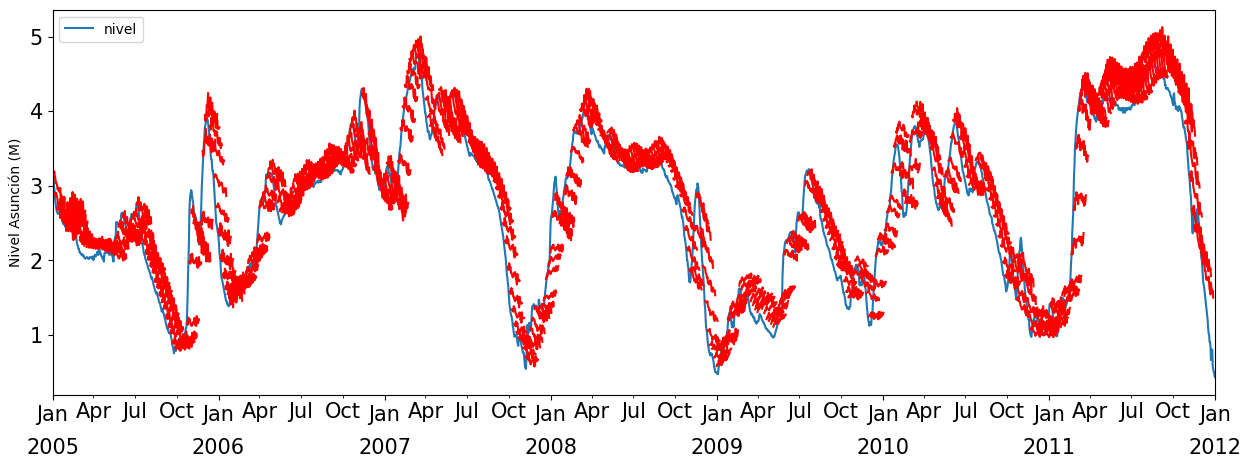

In [117]:
df = val[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()

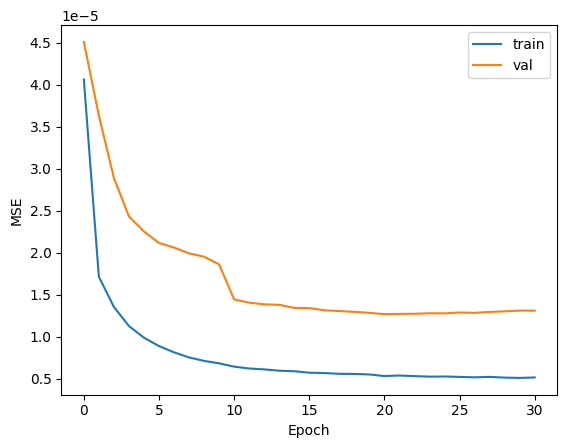

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [120]:
desde = (dt.datetime.strptime('2013-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2018-01-01' hasta 'tamanio_ventana' días antes
test = datos_normm.loc[desde:'2022-01-01'] # Toma el conjunto de datos para la test
ix = test.index # Toma los indices del conjunto de datos de test
testScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de test
testScaler.fit(test) # Ajusta la normalización a los datos de test
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns) # Crea un dataframe con el conjunto de datos de test normalizados y ajustados
testScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_test, y_test = preparar_datos(tamanio_ventana,horizonte, testScaled) # Divide los datos de test

In [121]:
Y_prediction = testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Predicción del modelo sobre los datos de test, y luego aplica una transformación inversa para delver los datos a su escala original
y_test_inv = testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Transformación inversa de 'y_test' a su escala original
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_test_inv, Y_prediction) # Error máximo entre y_test_inv e y y_prediction
r2_ = r2_score(y_test_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de test. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_test_inv - Y_prediction) ** 2) / np.sum((y_test_inv - np.mean(y_test_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

102/102 [==============================] - 1s 6ms/step
MSE: 0.4499524241825595 RMSE:0.670784931391992
MaxError: 4.603036008179188 R2:0.8897177383448103
NSE: 0.8897177383448103
Time step : 392.823835 seconds


In [26]:
desde = (dt.datetime.strptime('2005-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2014-01-01' hasta 'tamanio_ventana' días antes
val = datos_normm.loc[desde:'2012-01-01'] # Toma el conjunto de datos para la validación 
ix = val.index # Toma los indices del conjunto de datos de validación
valScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de validación
valScaler.fit(val) # Ajusta la normalización a los datos de validación
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns) # Crea un dataframe con el conjunto de datos de validación normalizados y ajustados
valScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_val, y_val = preparar_datos(tamanio_ventana,horizonte, valScaled) # Divide los datos de validación

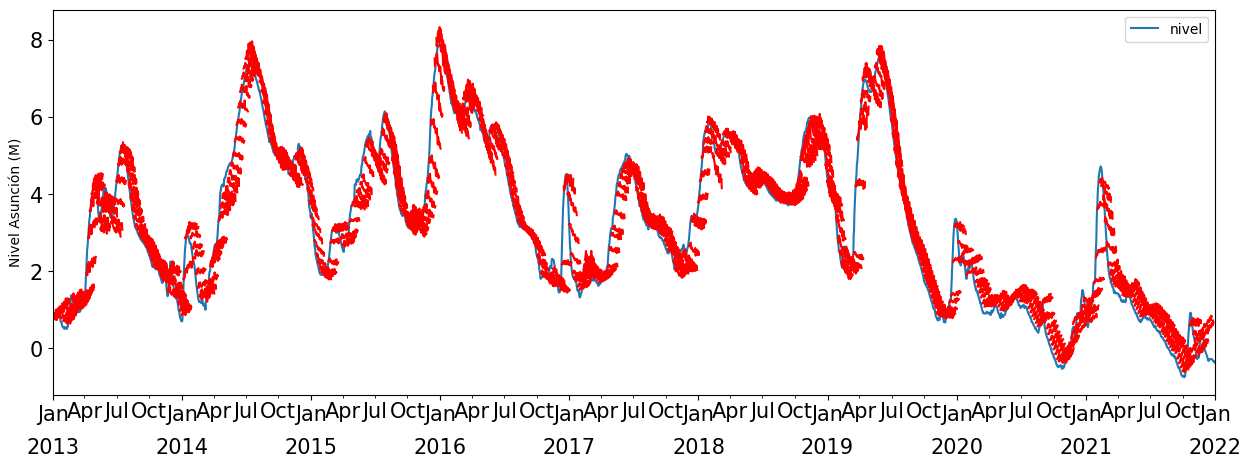

In [122]:
df = test[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()